In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.cluster
from PIL import Image
import os


In [2]:
# DATAPATHS

base_datapath = 'PlantVillage/'

potato_healthy = base_datapath + 'Potato___healthy/'
potato_late_blight = base_datapath + 'Potato___Late_blight/'
potato_early_blight = base_datapath + 'Potato___Early_blight/'

In [3]:
# DATASET PIXELS LOADER
def load_dataset_pixels(datapath, sampling_dimension = None):
    X = np.array([])

    for img in os.listdir(datapath):
        img = Image.open(datapath + img)
        if sampling_dimension is not None:
            img = img.resize((sampling_dimension, sampling_dimension))
        img = np.array(img)
        img = img.reshape(-1, 3)
        if X.size == 0:
            X = img
        else:
            X = np.concatenate((X, img), axis=0)

    return X

# MODEL FACTORY
def model_factory(n_clusters=8, max_iter=300):
    return sklearn.cluster.KMeans(n_clusters=n_clusters, max_iter=max_iter)

# IMAGE PIXELS CLASSIFIER
def classify_pixels(image_path, model, imscale=None):
    img = Image.open(image_path)
    if imscale is not None:
        img = img.resize((imscale, imscale))
    img = np.array(img)
    img_reshaped = img.reshape(-1, 3)

    predicted = model.predict(img_reshaped)
    classified_image = model.cluster_centers_[predicted].astype(int).reshape(img.shape)

    return Image.fromarray(np.uint8(classified_image))

def classify_with_custom_palette(image_path, model, palette, imscale=None):
    img = Image.open(image_path)
    if imscale is not None:
        img = img.resize((imscale, imscale))
    img = np.array(img)
    img_reshaped = img.reshape(-1, 3)

    predicted = model.predict(img_reshaped)
    classified_image = palette[predicted].astype(int).reshape(img.shape)

    return Image.fromarray(np.uint8(classified_image))

# CLUSTER PALATTE VISUALIZER
def create_palette_image(cluster_centers, image_size=100):
    # Create a blank image
    palette_image = Image.new("RGB", (image_size * len(cluster_centers), image_size))
    
    # Iterate through each cluster center and fill the corresponding portion of the image
    for i, center in enumerate(cluster_centers):
        color = tuple(map(int, center))
        palette_image.paste(color, (i * image_size, 0, (i + 1) * image_size, image_size))
    
    return palette_image

# RANDOM IMAGE SELECTOR
def select_random_image(datapath):
    return datapath + np.random.choice(os.listdir(datapath))

In [66]:
# PIXEL ARRAYS

healthy_pixel_array = load_dataset_pixels(potato_healthy, 100)

late_blight_pixel_array = load_dataset_pixels(potato_late_blight,100)

early_blight_pixel_array = load_dataset_pixels(potato_early_blight, 100)

In [67]:
healthy_model = model_factory(48)

healthy_model.fit(healthy_pixel_array)

KMeans(n_clusters=48)

In [68]:
early_blight_model = model_factory(48)

early_blight_model.fit(early_blight_pixel_array)

KMeans(n_clusters=48)

In [69]:
late_blight_model = model_factory(48)

late_blight_model.fit(late_blight_pixel_array)

KMeans(n_clusters=48)

In [91]:
def pixel_frequency(pixel_array, model):
    predicted = model.predict(pixel_array)
    vc = pd.Series(predicted).value_counts()
    vc.sort_index(inplace=True)
    return np.array([vc.get(i) / len(predicted) if vc.get(i) is not None else 0 for i in range(model.n_clusters)])

In [421]:
healthy_freq = pixel_frequency(healthy_pixel_array, early_blight_model)

early_blight_freq = pixel_frequency(early_blight_pixel_array, early_blight_model)

difference = early_blight_freq - healthy_freq

special = difference > 0.005

special_palette = np.array([[255,0,0] if special[i] else early_blight_model.cluster_centers_[i] for i in range(early_blight_model.n_clusters)])

special_palette = special_palette.astype(int)

other_difference = healthy_freq - early_blight_freq

other_special = other_difference > 0.005

other_special_palette = np.array([[0,0,255] if other_special[i] else special_palette[i] for i in range(healthy_model.n_clusters)])

other_special_palette = other_special_palette.astype(int)

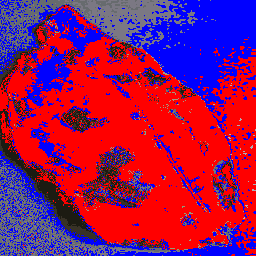

In [442]:
image = select_random_image(potato_early_blight)

classify_with_custom_palette(image, early_blight_model, other_special_palette)

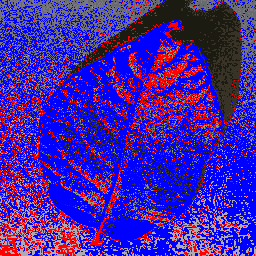

In [443]:
image = select_random_image(potato_healthy)

classify_with_custom_palette(image, early_blight_model, other_special_palette)